# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

- This script evaluates the performance of K-Means clustering on the California Housing dataset using Silhouette scores and the Elbow method for various values of k.
- It includes:
  1. Calculation of Silhouette scores for different cluster counts, plotting them to identify the optimal number of clusters based on this metric.
  2. Calculation of inertia for a range of k values to apply the Elbow method, visualizing inertia to determine the best k for clustering.
  3. Clustering the data using K-Means and plotting the geographical distribution of clusters using latitude and longitude coordinates.
  4. An animated visualization of the centroid initialization and movement process across iterations to demonstrate how centroids converge over time.
- Each plot includes configurations for axes, labels, titles, and grid lines, providing a clear visual representation of the clustering analysis and results.

# Data Loading & Preprocessing

In [2]:
path = 'C:\\Users\\zcindemir\\Desktop\\Data Mining Project\\housing.csv'
housing = pd.read_csv(path)

housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)

encoder = OneHotEncoder()
ocean_proximity_encoded = encoder.fit_transform(housing[['ocean_proximity']]).toarray()
feature_names = encoder.get_feature_names_out(['ocean_proximity'])
ocean_proximity_df = pd.DataFrame(ocean_proximity_encoded, columns=feature_names)
housing_encoded = pd.concat([housing.drop('ocean_proximity', axis=1), ocean_proximity_df], axis=1)

scaler = StandardScaler()
housing_scaled = scaler.fit_transform(housing_encoded)

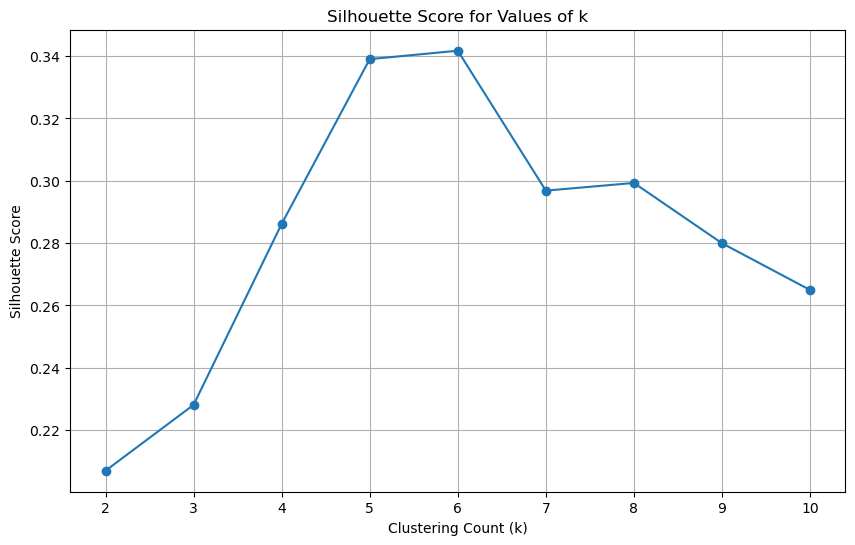

In [3]:
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(housing_scaled)
    clusters = kmeans.labels_
    score = silhouette_score(housing_scaled, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xticks(K_range)
plt.xlabel('Clustering Count (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Values of k')
plt.grid(True)
plt.show()

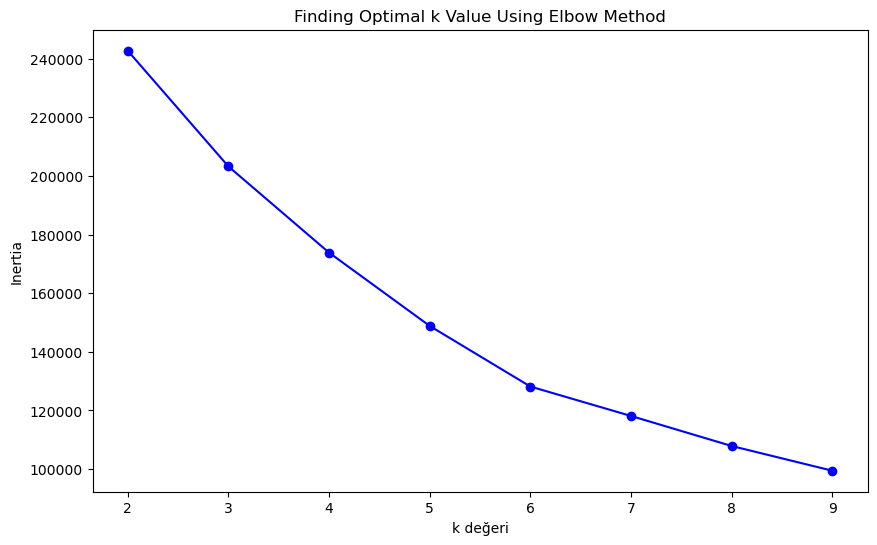

In [4]:
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(housing_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('k değeri')
plt.ylabel('Inertia')
plt.title('Finding Optimal k Value Using Elbow Method')
plt.show()

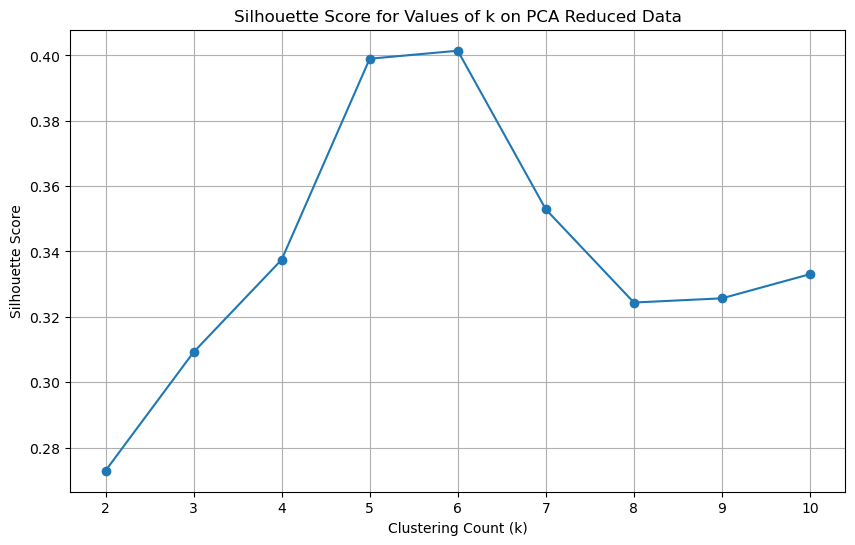

In [5]:
pca = PCA(n_components=4)
housing_pca = pca.fit_transform(housing_scaled)

silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(housing_pca)
    clusters = kmeans.labels_
    score = silhouette_score(housing_pca, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xticks(K_range)
plt.xlabel('Clustering Count (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Values of k on PCA Reduced Data')
plt.grid(True)
plt.show()

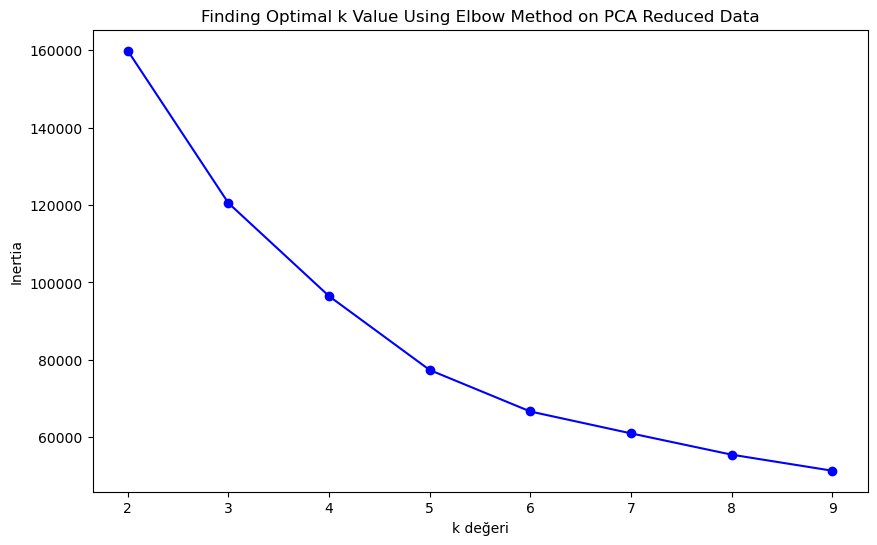

In [6]:
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(housing_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('k değeri')
plt.ylabel('Inertia')
plt.title('Finding Optimal k Value Using Elbow Method on PCA Reduced Data')
plt.show()

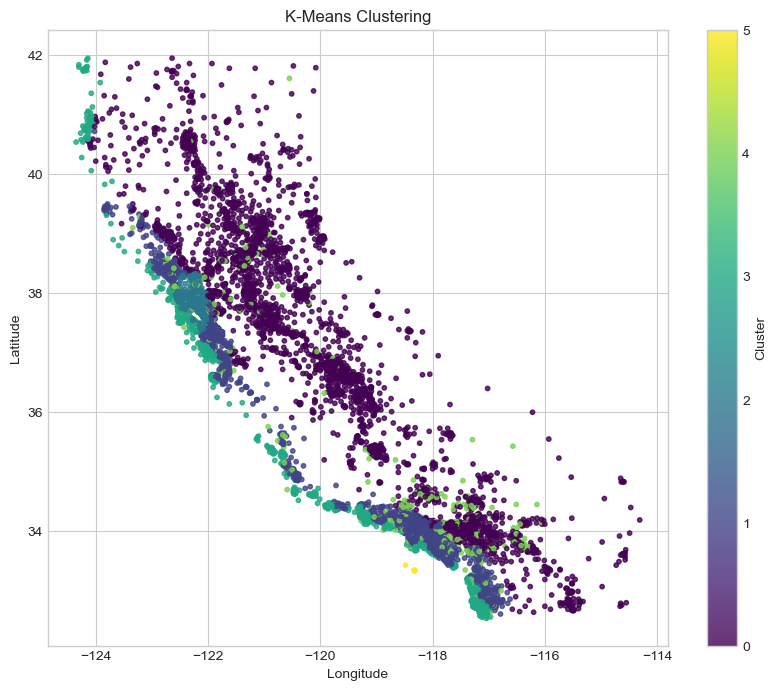

In [7]:
kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
kmeans.fit(housing_scaled)
clusters = kmeans.labels_

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))
scatter = plt.scatter(housing['longitude'], housing['latitude'], c=clusters, cmap='viridis', s=10, alpha=0.8, label='Clusters')
plt.colorbar(scatter, label='Cluster')
plt.title('K-Means Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

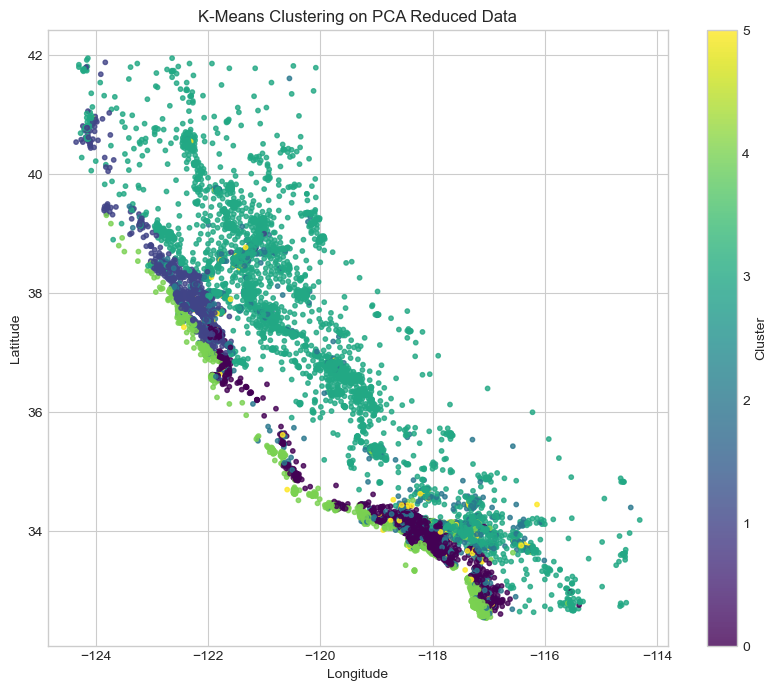

In [8]:
kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
kmeans.fit(housing_pca)
clusters = kmeans.labels_

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))
scatter = plt.scatter(housing['longitude'], housing['latitude'], c=clusters, cmap='viridis', s=10, alpha=0.8, label='Clusters')
plt.colorbar(scatter, label='Cluster')
plt.title('K-Means Clustering on PCA Reduced Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [9]:
sns.set(style="whitegrid")

longitude_index = housing_encoded.columns.get_loc("longitude")
latitude_index = housing_encoded.columns.get_loc("latitude")

def initialize_centroids(points, k):
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

def move_centroids(points, closest, centroids):
    return np.array([points[closest == k].mean(axis=0) for k in range(centroids.shape[0])])


k = 6
centroids = initialize_centroids(housing_scaled, k)
colors = sns.color_palette(n_colors=k)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([housing['longitude'].min(), housing['longitude'].max()])
ax.set_ylim([housing['latitude'].min(), housing['latitude'].max()])

def animate(i):
    global centroids
    closest = closest_centroid(housing_scaled, centroids)
    centroids = move_centroids(housing_scaled, closest, centroids)
    
    ax.clear()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    for idx in range(k):
        cluster_points = housing_scaled[closest == idx]
        points = scaler.inverse_transform(cluster_points)
        ax.scatter(points[:, longitude_index], points[:, latitude_index], c=[colors[idx]], alpha=0.6)

    centroid_points = scaler.inverse_transform(centroids)
    ax.scatter(centroid_points[:, longitude_index], centroid_points[:, latitude_index], c='red', s=100, edgecolors='black', marker='X')

ani = animation.FuncAnimation(fig, animate, frames=25, interval=300)

plt.close()
HTML(ani.to_jshtml())